In [423]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')

from matplotlib import font_manager
f_path = '/Library/Fonts/Arial Unicode.ttf'
font_manager.FontProperties(fname=f_path).get_name()
from matplotlib import rc
rc('font', family = 'Arial Unicode MS')

In [424]:
# 데이터 가지고오기
socar_df = pd.read_csv("../../0. raw_data/insurance_fraud_detect_data.csv")
pd.set_option('display.max_columns', len(socar_df.columns))
socar_df.head()

,fraud_YN,car_model,sharing_type,age_group,has_previous_accident,cumulative_use_count,b2b,accident_ratio,pf_type,socarpass,socarsave,start_hour,duration,accident_hour,repair_cost,insure_cost,accident_location,car_part1,car_part2,repair_cnt,acc_type1,insurance_site_aid_YN,police_site_aid_YN,total_prsn_cnt,test_set
0,0,2,1,3,0,2,0,100,2,0,0,4,2,4,1.302547e+05,0,1,0,0,1,0,0,0,-1,0
1,0,1,0,4,0,4,0,0,3,1,0,1,4,4,0.000000e+00,0,1,1,1,2,1,1,1,0,1
2,0,1,0,4,1,4,0,100,3,1,0,1,4,6,2.581306e+05,12925040,3,1,0,2,1,1,1,0,1
3,0,3,1,3,0,4,0,0,2,0,0,3,3,5,1.341009e+06,0,3,1,0,1,0,0,0,-1,0
4,0,1,0,1,0,1,0,100,1,0,0,1,1,1,5.240306e+05,1209410,1,0,0,2,0,0,0,-1,0


In [425]:
# column 확인
socar_df.columns

Index(['fraud_YN', 'car_model', 'sharing_type', 'age_group',
       'has_previous_accident', 'cumulative_use_count', 'b2b',
       'accident_ratio', 'pf_type', 'socarpass', 'socarsave', 'start_hour',
       'duration', 'accident_hour', 'repair_cost', 'insure_cost',
       'accident_location', 'car_part1', 'car_part2', 'repair_cnt',
       'acc_type1', 'insurance_site_aid_YN', 'police_site_aid_YN',
       'total_prsn_cnt', 'test_set'],
      dtype='object')

In [426]:
# test 셋 분리해놓고, test column 삭제
train_df = socar_df[socar_df.test_set == 0]
final_test_df = socar_df[socar_df.test_set == 1]
train_df.drop(['test_set'], axis=1, inplace=True)
final_test_df.drop(['test_set'], axis=1, inplace=True)

In [427]:
train_df.reset_index(drop=True, inplace=True)
final_test_df.reset_index(drop=True, inplace=True)

In [428]:
# 나중에 test 세트를 예측해야 하니까 test 세트도 변수에 넣어줌.
# final 붙은 data는 최종 성능 점검에서만 사용 !
X_final_test = final_test_df.iloc[:, 1:]
y_fianl_test = final_test_df.iloc[:, 0]

In [429]:
# 전체 데이터와 사기 데이터의 분포가 똑같아서 뭔가 ~ 분류에 쓸데 없어보이는 컬럼제거
train_df.drop(columns=['sharing_type', 'has_previous_accident','b2b','accident_ratio','socarpass','socarsave', 'car_part2'], inplace=True)
train_df.columns

Index(['fraud_YN', 'car_model', 'age_group', 'cumulative_use_count', 'pf_type',
       'start_hour', 'duration', 'accident_hour', 'repair_cost', 'insure_cost',
       'accident_location', 'car_part1', 'repair_cnt', 'acc_type1',
       'insurance_site_aid_YN', 'police_site_aid_YN', 'total_prsn_cnt'],
      dtype='object')

In [430]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    train_df.values, i) for i in range(train_df.shape[1])]
vif["features"] = train_df.columns
vif

,VIF Factor,features
0,1.004049,fraud_YN
1,5.362191,car_model
2,5.444233,age_group
3,5.757838,cumulative_use_count
4,6.514144,pf_type
5,6.283298,start_hour
6,4.407132,duration
7,4.788582,accident_hour
8,1.494093,repair_cost
9,1.197566,insure_cost


In [431]:
# VIF 10이상인 변수 제거
train_df.drop(columns=['police_site_aid_YN', 'acc_type1'], inplace=True)
train_df.columns

Index(['fraud_YN', 'car_model', 'age_group', 'cumulative_use_count', 'pf_type',
       'start_hour', 'duration', 'accident_hour', 'repair_cost', 'insure_cost',
       'accident_location', 'car_part1', 'repair_cnt', 'insurance_site_aid_YN',
       'total_prsn_cnt'],
      dtype='object')

In [432]:
# 학습해야 할 train 세트 - 타겟변수와 피쳐 분리
X = train_df.iloc[:, 1:]
y = train_df.iloc[:, 0]

X.shape, y.shape

((12879, 14), (12879,))

### 1. Original Data

In [276]:
# train_set 내에서 train / test(validation) set 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13, stratify=y)

In [277]:
import numpy as np

np.unique(y_train, return_counts=True)

(array([0, 1]), array([8991,   24]))

In [278]:
tmp = np.unique(y_train, return_counts=True)[1]
tmp[1]/len(y_train) *100

0.26622296173044924

In [279]:
tmp = np.unique(y_test, return_counts=True)[1]
tmp[1]/len(y_test) *100

0.2587991718426501

In [280]:
# 성능지표 반환 함수 생성
from sklearn.metrics import(accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)

def get_clf_eval(y_test, pred):
    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    re = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred)
    
    return acc, pre, re, f1, auc

In [281]:
# confusion_matrix 생성함수
from sklearn.metrics import confusion_matrix

def print_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    acc, pre, re, f1, auc = get_clf_eval(y_test, pred)
    
    print('=> confusion matrix')
    print(confusion)
    print('====================')
    
    print('Accuracy: {0:.4f}, Precision: {1:.4f}'.format(acc, pre))
    print('Recall: {0:.4f}, F1: {1:.4f}, AUC: {2:.4f}'.format(re, f1, auc))

### 분류모델 
- 1. Logistic Regression
- 2. Decision Tree
- 3. Random Forest
- 4. LightGBM

In [282]:
# logistic regression
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(random_state=13, solver='liblinear')
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

print_clf_eval(y_test, lr_pred)

=> confusion matrix
[[3854    0]
 [  10    0]]
Accuracy: 0.9974, Precision: 0.0000
Recall: 0.0000, F1: 0.0000, AUC: 0.5000


In [283]:
# decision tree
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=13, max_depth=2)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)

print_clf_eval(y_test, dt_pred)

=> confusion matrix
[[3854    0]
 [  10    0]]
Accuracy: 0.9974, Precision: 0.0000
Recall: 0.0000, F1: 0.0000, AUC: 0.5000


In [284]:
# random forest
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=13, n_jobs=1, n_estimators=300)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

print_clf_eval(y_test, rf_pred)

=> confusion matrix
[[3854    0]
 [  10    0]]
Accuracy: 0.9974, Precision: 0.0000
Recall: 0.0000, F1: 0.0000, AUC: 0.5000


In [285]:
# lgbm
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=1,
                         boost_from_average=False)
lgbm_clf.fit(X_train, y_train)
lgbm_pred= lgbm_clf.predict(X_test)

print_clf_eval(y_test, lgbm_pred)

=> confusion matrix
[[3854    0]
 [  10    0]]
Accuracy: 0.9974, Precision: 0.0000
Recall: 0.0000, F1: 0.0000, AUC: 0.5000


In [286]:
# 모델과 데이터를 주면 성능을 출력하는 함수 
def get_result(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    return get_clf_eval(y_test, pred)

In [287]:
# 다수의 모델 성능을 정리해서 DataFrame으로 반환
def get_result_pd(models, model_names, X_train, y_train, X_test, y_test):
    col_names = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    tmp =[]
    
    for model in models:
        tmp.append(get_result(model, X_train, y_train, X_test, y_test))
        
    return pd.DataFrame(tmp, columns=col_names, index=model_names)

In [288]:
# 4개의 분류모델 표로 정리
import time

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

start_time = time.time()
results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

print('Fit time: ', time.time() - start_time)
results

Fit time:  2.2044308185577393


,accuracy,precision,recall,f1,roc_auc
LogisticReg,0.997412,0.0,0.0,0.0,0.5
DecisionTree,0.997412,0.0,0.0,0.0,0.5
RandomForest,0.997412,0.0,0.0,0.0,0.5
LightGBM,0.997412,0.0,0.0,0.0,0.5


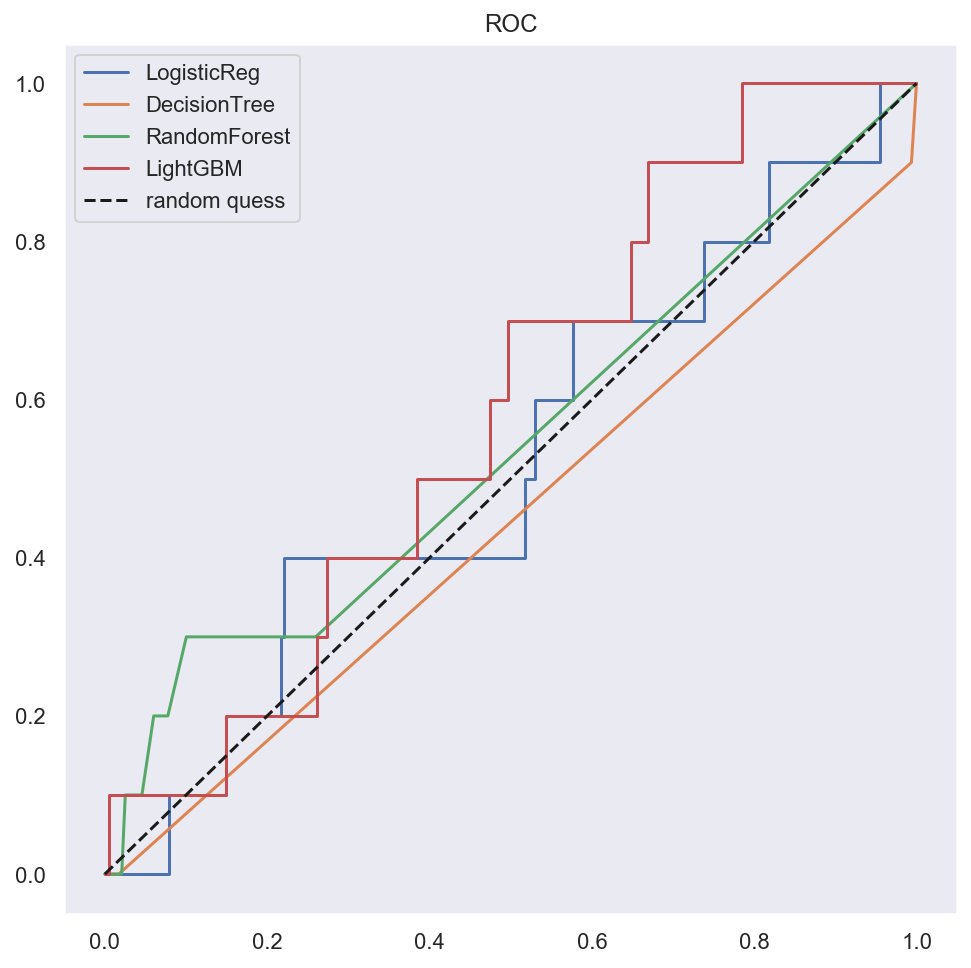

In [289]:
from sklearn.metrics import roc_curve

def draw_roc_curve(model, model_names, X_test, y_test):
    plt.figure(figsize=(8,8))
    
    for model in range(len(models)):
        pred = models[model].predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, pred)
        plt.plot(fpr, tpr, label = model_names[model])
        
    plt.plot([0,1], [0,1], 'k--', label = 'random quess')
    plt.title('ROC')
    plt.legend()
    plt.grid()
    plt.show()

draw_roc_curve(models, model_names, X_test, y_test)   

### 2. StandardScale to sequential features

''

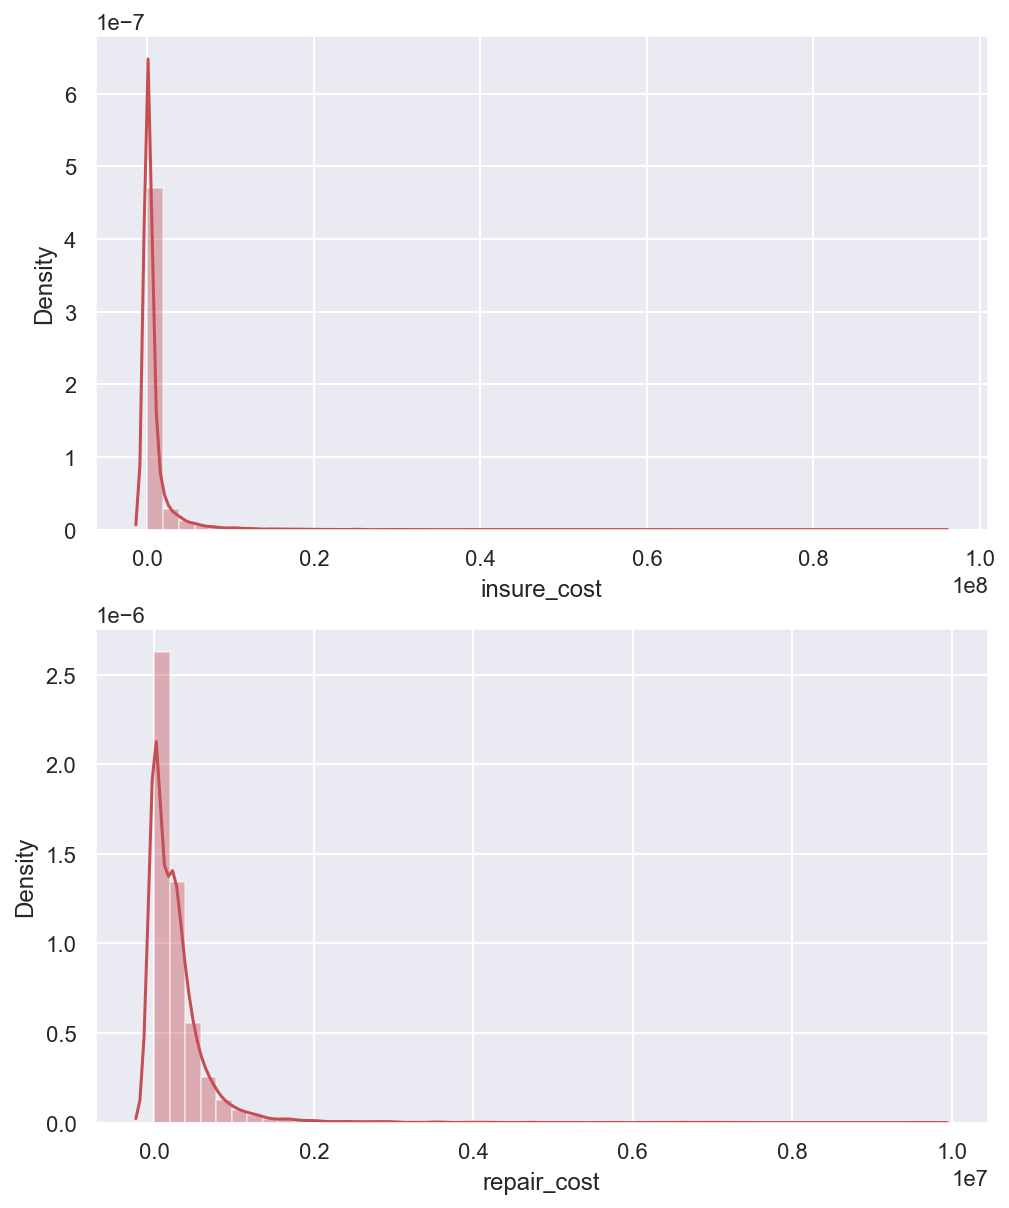

In [290]:
# 연속형 변수는 2개, 분포를 확인해보자
f, ax = plt.subplots(2, 1, figsize = (8, 10))

sns.distplot(train_df["insure_cost"], color="r", ax = ax[0])
sns.distplot(train_df["repair_cost"], color="r", ax = ax[1])
;
# 한쪽으로 매우 치우쳐져있다 -> 표준화

In [291]:
# train_df 에서 연속형 변수 가져와서 scaled feature 만들고
# target feature 및 original 연속형변수 삭제
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
insure_n = scaler.fit_transform(train_df['insure_cost'].values.reshape(-1,1))
repair_n = scaler.fit_transform(train_df['repair_cost'].values.reshape(-1,1))

X_ss = train_df.drop(['fraud_YN', 'insure_cost', 'repair_cost'], axis=1) 
X_ss['scaled_insure_cost'] = insure_n
X_ss['scaled_repair_cost'] = repair_n

X_ss.head()

,car_model,age_group,cumulative_use_count,pf_type,start_hour,duration,accident_hour,accident_location,car_part1,repair_cnt,insurance_site_aid_YN,total_prsn_cnt,scaled_insure_cost,scaled_repair_cost
0,2,3,2,2,4,2,4,1,0,1,0,-1,-0.273447,-0.296588
1,3,3,4,2,3,3,5,3,1,1,0,-1,-0.273447,2.047627
2,1,1,1,1,1,1,1,1,0,2,0,-1,0.121310,0.465826
3,1,3,4,3,6,3,1,0,0,1,2,2,0.123879,-0.548781
4,2,4,4,1,4,2,6,1,0,1,1,2,-0.273447,-0.548781


In [292]:
# train_set 내에서 train / test(validation) set 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_ss, y, test_size=0.3, random_state=13, stratify=y)

In [293]:
models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

start_time = time.time()
results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

print('Fit time: ', time.time() - start_time)
results

Fit time:  2.1320247650146484


,accuracy,precision,recall,f1,roc_auc
LogisticReg,0.997412,0.0,0.0,0.0,0.5
DecisionTree,0.997412,0.0,0.0,0.0,0.5
RandomForest,0.997412,0.0,0.0,0.0,0.5
LightGBM,0.997412,0.0,0.0,0.0,0.5


##### * 소름이 끼칠 정도로 original data와 존. 똑.

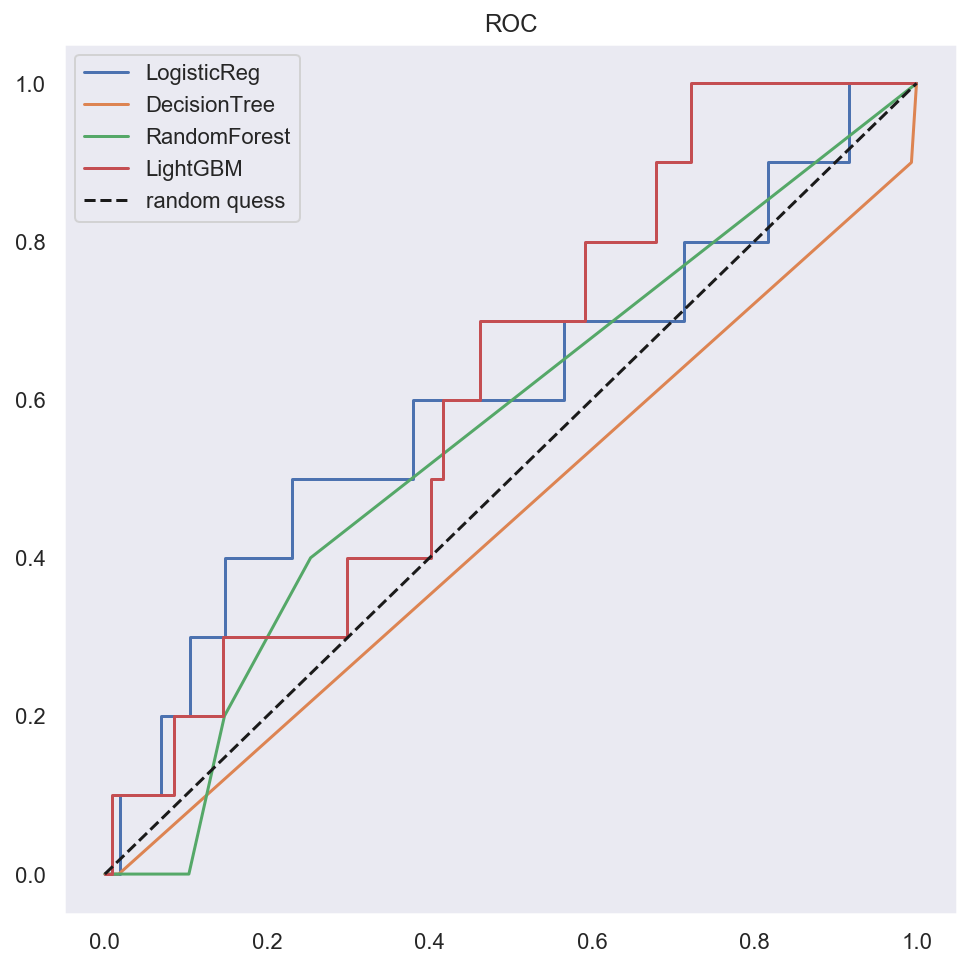

In [294]:
from sklearn.metrics import roc_curve

def draw_roc_curve(model, model_names, X_test, y_test):
    plt.figure(figsize=(8,8))
    
    for model in range(len(models)):
        pred = models[model].predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, pred)
        plt.plot(fpr, tpr, label = model_names[model])
        
    plt.plot([0,1], [0,1], 'k--', label = 'random quess')
    plt.title('ROC')
    plt.legend()
    plt.grid()
    plt.show()

draw_roc_curve(models, model_names, X_test, y_test)   

### 3. log scale

In [295]:
insure_log = np.log1p(train_df['insure_cost'])
repair_log = np.log1p(train_df['repair_cost'])

X_ls= train_df.drop(['insure_cost', 'repair_cost', 'fraud_YN'], axis=1) 
X_ls['scaled_insure_cost'] = insure_log
X_ls['scaled_repair_cost'] = repair_log

X_ls.head()

,car_model,age_group,cumulative_use_count,pf_type,start_hour,duration,accident_hour,accident_location,car_part1,repair_cnt,insurance_site_aid_YN,total_prsn_cnt,scaled_insure_cost,scaled_repair_cost
0,2,3,2,2,4,2,4,1,0,1,0,-1,0.000000,11.777255
1,3,3,4,2,3,3,5,3,1,1,0,-1,0.000000,14.108934
2,1,1,1,1,1,1,1,1,0,2,0,-1,14.005644,13.169307
3,1,3,4,3,6,3,1,0,0,1,2,2,14.012130,0.000000
4,2,4,4,1,4,2,6,1,0,1,1,2,0.000000,0.000000


In [296]:
# train_set 내에서 train / test(validation) set 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_ls, y, test_size=0.3, random_state=13, stratify=y)

In [297]:
models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

start_time = time.time()
results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

print('Fit time: ', time.time() - start_time)
results

# standard scale과 성능이 똑같아서 roc auc 안그림

Fit time:  2.2067761421203613


,accuracy,precision,recall,f1,roc_auc
LogisticReg,0.997412,0.0,0.0,0.0,0.5
DecisionTree,0.997412,0.0,0.0,0.0,0.5
RandomForest,0.997412,0.0,0.0,0.0,0.5
LightGBM,0.997412,0.0,0.0,0.0,0.5


### 4. remove outlier

In [433]:
# 사기 데이터라 비용이 fraud가 이상치에서 발생했나 보려고 fraud YN 에 따라 plot 따로 그려봄
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Box(y = train_df[train_df['fraud_YN']==0]['insure_cost'], name = 'insure_cost_0'))
fig.add_trace(go.Box(y = train_df[train_df['fraud_YN']==1]['insure_cost'], name = 'insure_cost_1'))

fig.add_trace(go.Box(y = train_df[train_df['fraud_YN']==0]['repair_cost'], name = 'repair_cost_0'))
fig.add_trace(go.Box(y = train_df[train_df['fraud_YN']==1]['repair_cost'], name = 'repair_cost_1'))

# 이상치가 fraud data에 영향을 끼칠것 같지는 않음

In [434]:
# 이상치 제거하는 함수 생성

def get_outlier(df=None, column=None, weight=1.5):
    fraud= df[df["fraud_YN"]==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_25 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 = quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    
    return outlier_index

In [435]:
# insure_cost에서는 최대치를 벗어나는 값이 3개 있었음
get_outlier(df=train_df, column="insure_cost", weight=1.5)

Int64Index([92, 342, 3773], dtype='int64')

In [436]:
# repair_cost에서는 최대치를 벗어나는 값이 2개 있었음
get_outlier(df=train_df, column="repair_cost", weight=1.5)

Int64Index([12, 4576], dtype='int64')

In [437]:
# 이상치 제거, 중복 index 있으면 unique하게 남겨두기
outlier_index = list(get_outlier(df=train_df, column="insure_cost", weight=1.5)) + list(get_outlier(df=train_df, column="repair_cost", weight=1.5))
outlier_index = set(outlier_index)

# origianl data 이상치 제거 
X_rmol = X.drop(outlier_index, axis=0)

# standard scaled data 이상치 제거 
X_ss_rmol = X_ss.drop(outlier_index, axis=0)

# log scaled data 이상치 제거
X_ls_rmol = X_ls.drop(outlier_index, axis=0)

# target 변수 이상치 제거 
y_rmol = y.drop(outlier_index, axis=0)

In [438]:
X_rmol.shape, X_ss_rmol.shape, X_ls_rmol.shape, y_rmol.shape

((12874, 14), (12874, 14), (12874, 14), (12874,))

In [439]:
# original 이상치 제거
X_train, X_test, y_train, y_test = train_test_split(X_rmol, y_rmol, test_size=0.3, random_state=13, stratify=y_rmol)

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

start_time = time.time()
results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

print('Fit time: ', time.time() - start_time)
results

Fit time:  2.097062110900879


,accuracy,precision,recall,f1,roc_auc
LogisticReg,0.99767,0.0,0.0,0.0,0.5
DecisionTree,0.99767,0.0,0.0,0.0,0.5
RandomForest,0.99767,0.0,0.0,0.0,0.5
LightGBM,0.99767,0.0,0.0,0.0,0.5


In [440]:
# standard scale 이상치 제거

In [441]:
X_train, X_test, y_train, y_test = train_test_split(X_ss_rmol, y_rmol, test_size=0.3, random_state=13, stratify=y_rmol)

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

start_time = time.time()
results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

print('Fit time: ', time.time() - start_time)
results

Fit time:  1.960726022720337


,accuracy,precision,recall,f1,roc_auc
LogisticReg,0.99767,0.0,0.0,0.0,0.5
DecisionTree,0.99767,0.0,0.0,0.0,0.5
RandomForest,0.99767,0.0,0.0,0.0,0.5
LightGBM,0.99767,0.0,0.0,0.0,0.5


In [442]:
# log scale 이상치 제거
X_train, X_test, y_train, y_test = train_test_split(X_ls_rmol, y_rmol, test_size=0.3, random_state=13, stratify=y_rmol)

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

start_time = time.time()
results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

print('Fit time: ', time.time() - start_time)
results

Fit time:  2.0782699584960938


,accuracy,precision,recall,f1,roc_auc
LogisticReg,0.99767,0.0,0.0,0.0,0.5
DecisionTree,0.99767,0.0,0.0,0.0,0.5
RandomForest,0.99767,0.0,0.0,0.0,0.5
LightGBM,0.99767,0.0,0.0,0.0,0.5


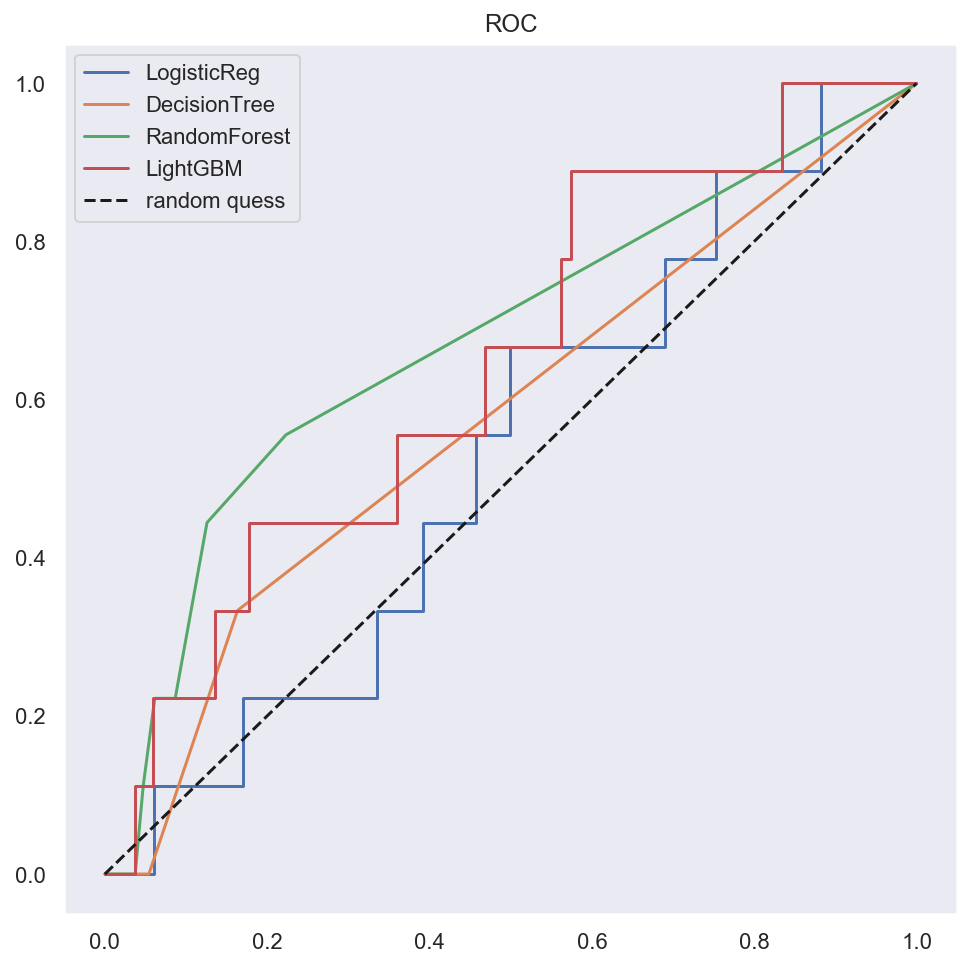

In [443]:
from sklearn.metrics import roc_curve

def draw_roc_curve(model, model_names, X_test, y_test):
    plt.figure(figsize=(8,8))
    
    for model in range(len(models)):
        pred = models[model].predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, pred)
        plt.plot(fpr, tpr, label = model_names[model])
        
    plt.plot([0,1], [0,1], 'k--', label = 'random quess')
    plt.title('ROC')
    plt.legend()
    plt.grid()
    plt.show()

draw_roc_curve(models, model_names, X_test, y_test)   

### 5. Over sampling

In [444]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

In [445]:
X_train_over.shape, y_train_over.shape, X_train.shape, y_train.shape

((17982, 14), (17982,), (9011, 14), (9011,))

In [446]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_train_over, return_counts=True))

(array([0, 1]), array([8991,   20]))
(array([0, 1]), array([8991, 8991]))


In [447]:
models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

start_time = time.time()
results = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)

print('Fit time: ', time.time() - start_time)
results

Fit time:  4.647290229797363


,accuracy,precision,recall,f1,roc_auc
LogisticReg,0.747864,0.002064,0.222222,0.004090,0.485657
DecisionTree,0.827077,0.004511,0.333333,0.008902,0.580782
RandomForest,0.996376,0.000000,0.000000,0.000000,0.499351
LightGBM,0.996117,0.000000,0.000000,0.000000,0.499222


In [448]:
# 4개의 분류모델 표로 정리
import time

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

start_time = time.time()
results = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)

print('Fit time: ', time.time() - start_time)
results

Fit time:  5.183608055114746


,accuracy,precision,recall,f1,roc_auc
LogisticReg,0.747864,0.002064,0.222222,0.004090,0.485657
DecisionTree,0.827077,0.004511,0.333333,0.008902,0.580782
RandomForest,0.996376,0.000000,0.000000,0.000000,0.499351
LightGBM,0.996117,0.000000,0.000000,0.000000,0.499222


### pca

In [449]:
from sklearn.decomposition import PCA

def get_pca_data(data, n_components=5):
    pca = PCA(n_components=n_components)
    pca.fit(data)
    
    return pca.transform(data), pca

In [451]:
# logscale 된 변수 사용
socar_pca, pca = get_pca_data(X_ls_rmol, n_components=5)
socar_pca.shape

(12874, 5)

In [452]:
pca.components_

array([[ 1.31708849e-03, -1.11932583e-02,  8.99866219e-03,
         5.01616764e-03, -6.30882865e-03, -7.81004294e-03,
        -8.68558887e-03, -1.61526549e-02,  1.04726233e-02,
         1.18078334e-02,  2.58694200e-02,  4.20186806e-02,
         9.49153252e-01,  3.09441270e-01],
       [-2.07618795e-03,  7.67087779e-03,  4.96807278e-03,
        -6.55948066e-03,  8.49512195e-03,  7.20877776e-03,
         1.57994295e-02, -1.57781502e-02, -1.12476610e-03,
        -1.89842989e-02,  2.19268682e-02,  3.15467962e-02,
         3.08047173e-01, -9.50008271e-01],
       [ 2.83776956e-03, -6.43284962e-02,  6.90814338e-02,
         1.74284497e-02, -5.85167257e-01, -1.83492582e-02,
        -8.01190483e-01,  7.25020146e-02,  2.88080717e-04,
         1.07345127e-02, -6.02127225e-03, -1.40760919e-02,
        -3.75216430e-03, -2.22231213e-02],
       [-3.82057174e-02, -1.74015911e-01, -2.05438495e-01,
        -4.31707961e-02,  7.47217549e-01, -2.36958492e-01,
        -5.29254574e-01,  1.67288501e-01, -1.

In [453]:
def get_pd_from_pca(pca_data, cols=['pca_col_1', 'pca_col_2', 'pca_col_3', 'pca_col_4', 'pca_col_5']):
    return pd.DataFrame(pca_data, columns=cols)

In [454]:
socar_pca_df = get_pd_from_pca(socar_pca)
socar_pca_df.head()

,pca_col_1,pca_col_2,pca_col_3,pca_col_4,pca_col_5
0,-3.488792,-5.145613,-0.816782,-0.167956,-0.298343
1,-2.779979,-7.371035,-0.816679,-1.816035,1.747950
2,10.307125,-2.264426,3.327197,0.110516,0.149792
3,6.387772,10.495800,0.633238,2.139273,-2.209070
4,-6.996818,6.215209,-2.149279,-1.785049,-0.209384


In [455]:
import numpy as np

print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))

[0.46218062 0.37646064 0.05085505 0.01958645 0.01789103]
0.9269737820012686


In [456]:
socar_pca_df.shape, y_rmol.shape

((12874, 5), (12874,))

In [458]:
X_train, X_test, y_train, y_test = train_test_split(socar_pca_df, y_rmol, test_size=0.3, random_state=13, stratify=y_rmol)

results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)
results
# oversampling 하지않으면 암것도 보이지 않는다. 

,accuracy,precision,recall,f1,roc_auc
LogisticReg,0.99767,0.0,0.0,0.0,0.5
DecisionTree,0.99767,0.0,0.0,0.0,0.5
RandomForest,0.99767,0.0,0.0,0.0,0.5
LightGBM,0.99767,0.0,0.0,0.0,0.5


In [459]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

In [461]:
results = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
results

# accuracyr가 많이 떨어지지만 recall이 좋아진다

,accuracy,precision,recall,f1,roc_auc
LogisticReg,0.584002,0.004342,0.777778,0.008637,0.680664
DecisionTree,0.230391,0.002351,0.777778,0.004687,0.503445
RandomForest,0.988869,0.000000,0.000000,0.000000,0.495589
LightGBM,0.988351,0.000000,0.000000,0.000000,0.495330


In [338]:
########## final test data 적용 ##############

In [462]:
# 불필요한 변수 삭제
socar_del = socar_df.drop(columns=['sharing_type', 'has_previous_accident','b2b','accident_ratio','socarpass','socarsave', 'car_part2','police_site_aid_YN', 'acc_type1'])
socar_del.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fraud_YN               16000 non-null  int64  
 1   car_model              16000 non-null  int64  
 2   age_group              16000 non-null  int64  
 3   cumulative_use_count   16000 non-null  int64  
 4   pf_type                16000 non-null  int64  
 5   start_hour             16000 non-null  int64  
 6   duration               16000 non-null  int64  
 7   accident_hour          16000 non-null  int64  
 8   repair_cost            16000 non-null  float64
 9   insure_cost            16000 non-null  int64  
 10  accident_location      16000 non-null  int64  
 11  car_part1              16000 non-null  int64  
 12  repair_cnt             16000 non-null  int64  
 13  insurance_site_aid_YN  16000 non-null  int64  
 14  total_prsn_cnt         16000 non-null  int64  
 15  te

In [463]:
# train set 에서 타겟변수의 이상치 제거
def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df['test_set']==0]
    fraud = fraud[fraud["fraud_YN"]==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_25 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 = quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    
    return outlier_index

In [464]:
# 이상치 제거, 중복 index 있으면 unique하게 남겨두기
outlier_index = list(get_outlier(df=socar_del, column="insure_cost", weight=1.5)) + list(get_outlier(df=socar_del, column="repair_cost", weight=1.5))
outlier_index = set(outlier_index)

# raw_data에서 이상치부터 제거
socar_rm_ol = socar_del.drop(outlier_index, axis=0)
socar_rm_ol.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15995 entries, 0 to 15999
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fraud_YN               15995 non-null  int64  
 1   car_model              15995 non-null  int64  
 2   age_group              15995 non-null  int64  
 3   cumulative_use_count   15995 non-null  int64  
 4   pf_type                15995 non-null  int64  
 5   start_hour             15995 non-null  int64  
 6   duration               15995 non-null  int64  
 7   accident_hour          15995 non-null  int64  
 8   repair_cost            15995 non-null  float64
 9   insure_cost            15995 non-null  int64  
 10  accident_location      15995 non-null  int64  
 11  car_part1              15995 non-null  int64  
 12  repair_cnt             15995 non-null  int64  
 13  insurance_site_aid_YN  15995 non-null  int64  
 14  total_prsn_cnt         15995 non-null  int64  
 15  te

In [465]:
# 예측변수와 목표편수 분리
socar_y = socar_rm_ol['fraud_YN']
socar_x = socar_rm_ol.drop(['fraud_YN'], axis=1)

In [466]:
# 로그 스케일링
insure_log = np.log1p(socar_x['insure_cost'])
repair_log = np.log1p(socar_x['repair_cost'])

socar_ls= socar_x.drop(['insure_cost', 'repair_cost'], axis=1) 
socar_ls['scaled_insure_cost'] = insure_log
socar_ls['scaled_repair_cost'] = repair_log

socar_ls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15995 entries, 0 to 15999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   car_model              15995 non-null  int64  
 1   age_group              15995 non-null  int64  
 2   cumulative_use_count   15995 non-null  int64  
 3   pf_type                15995 non-null  int64  
 4   start_hour             15995 non-null  int64  
 5   duration               15995 non-null  int64  
 6   accident_hour          15995 non-null  int64  
 7   accident_location      15995 non-null  int64  
 8   car_part1              15995 non-null  int64  
 9   repair_cnt             15995 non-null  int64  
 10  insurance_site_aid_YN  15995 non-null  int64  
 11  total_prsn_cnt         15995 non-null  int64  
 12  test_set               15995 non-null  int64  
 13  scaled_insure_cost     15995 non-null  float64
 14  scaled_repair_cost     15995 non-null  float64
dtypes:

In [468]:
def get_pd_from_pca(pca_data, cols=['pca_col_1', 'pca_col_2', 'pca_col_3']):
    return pd.DataFrame(pca_data, columns=cols)

In [469]:
# 주성분 분석 (n_component:3)
socar_pca, pca = get_pca_data(socar_x, n_components=3)
socar_pca.shape

(15995, 3)

In [470]:
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))

[9.74518786e-01 2.54812144e-02 5.13028618e-13]
0.9999999999988589


In [471]:
socar_pca_df = get_pd_from_pca(socar_pca)
socar_pca_df['fraud_YN'] = socar_y.values
socar_pca_df['test_set'] = socar_del_col['test_set']
socar_pca_df.tail()

,pca_col_1,pca_col_2,pca_col_3,fraud_YN,test_set
15990,-868985.300946,-248885.285237,3.561993,0,0
15991,-843394.834681,369024.474525,-2.754971,0,0
15992,-868985.300946,-248885.285238,0.312783,0,1
15993,-868985.300946,-248885.285238,0.089408,0,0
15994,334948.965017,93150.163481,-3.549058,0,0


In [472]:
socar_pca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15995 entries, 0 to 15994
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pca_col_1  15995 non-null  float64
 1   pca_col_2  15995 non-null  float64
 2   pca_col_3  15995 non-null  float64
 3   fraud_YN   15995 non-null  int64  
 4   test_set   15995 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 624.9 KB


In [473]:
# test 셋 분리해놓고, test column 삭제
train_df = socar_pca_df[socar_pca_df.test_set == 0]
final_test_df = socar_pca_df[socar_pca_df.test_set == 1]
train_df.drop(['test_set'], axis=1, inplace=True)
final_test_df.drop(['test_set'], axis=1, inplace=True)
final_test_df.tail()

,pca_col_1,pca_col_2,pca_col_3,fraud_YN
15974,-868985.300946,-248885.285238,-2.843192,0
15978,-868985.300946,-248885.285238,-2.922470,0
15983,-857586.175585,26359.047560,3.722887,0
15984,-854647.433647,97318.181565,1.779637,0
15992,-868985.300946,-248885.285238,0.312783,0


In [474]:
X_final_test = final_test_df.iloc[:, :-1]
y_final_test = final_test_df.iloc[:, -1]

In [475]:
X = train_df.iloc[:, :-1]
y = train_df.iloc[:, -1]

X.shape, y.shape

((12875, 3), (12875,))

In [476]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_sample(X, y)

In [477]:
results = get_result_pd(models, model_names, X_train_over, y_train_over, X_final_test, y_final_test)
results

,accuracy,precision,recall,f1,roc_auc
LogisticReg,0.329487,0.004292,0.692308,0.008531,0.510138
DecisionTree,0.775641,0.004329,0.230769,0.008499,0.504345
RandomForest,0.875641,0.010444,0.307692,0.020202,0.592855
LightGBM,0.935897,0.005291,0.076923,0.009901,0.508207


In [467]:
# 주성분 분석 (n_component:5)
socar_pca, pca = get_pca_data(socar_x, n_components=5)
socar_pca_df = get_pd_from_pca(socar_pca)
socar_pca_df['fraud_YN'] = socar_y.values
socar_pca_df['test_set'] = socar_del_col['test_set']
train_df = socar_pca_df[socar_pca_df.test_set == 0]
final_test_df = socar_pca_df[socar_pca_df.test_set == 1]
train_df.drop(['test_set'], axis=1, inplace=True)
final_test_df.drop(['test_set'], axis=1, inplace=True)
X_final_test = final_test_df.iloc[:, :-1]
y_final_test = final_test_df.iloc[:, -1]
X = train_df.iloc[:, :-1]
y = train_df.iloc[:, -1]

smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_sample(X, y)

results = get_result_pd(models, model_names, X_train_over, y_train_over, X_final_test, y_final_test)
results

,accuracy,precision,recall,f1,roc_auc
LogisticReg,0.329487,0.004292,0.692308,0.008531,0.510138
DecisionTree,0.864744,0.007229,0.230769,0.014019,0.549083
RandomForest,0.981731,0.000000,0.000000,0.000000,0.492919
LightGBM,0.984615,0.000000,0.000000,0.000000,0.494368


In [478]:
# 주성분 component 3일경우 randomforest와 lightGBM recall 성능이올라감
# Recall 이 좋아지면 accuracy가 떨어짐 . . 그래도 recall 높은게 더 좋은거 아닐까 . . ?
# precision은 정말 안올라온다 

In [479]:
# 내일은 threshold 변경하는거 해봐야지